In [68]:
import numpy as np
import pandas as pd
import functions as func
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

%matplotlib inline

db_locations = func.import_yaml()

#load df
df = pd.read_csv(db_locations['data_raw']['train'])
df_test = pd.read_csv(db_locations['data_raw']['test'])

### Understanding the Data

In [43]:
df.head(3)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900


In [69]:
list(df.select_dtypes("number"))

['id', 'model_year', 'milage', 'price']

In [45]:
df.select_dtypes("number").describe()

,id,model_year,milage,price
count,188533.000000,188533.000000,188533.000000,1.885330e+05
mean,94266.000000,2015.829998,65705.295174,4.387802e+04
std,54424.933488,5.660967,49798.158076,7.881952e+04
min,0.000000,1974.000000,100.000000,2.000000e+03
25%,47133.000000,2013.000000,24115.000000,1.700000e+04
50%,94266.000000,2017.000000,57785.000000,3.082500e+04
75%,141399.000000,2020.000000,95400.000000,4.990000e+04
max,188532.000000,2024.000000,405000.000000,2.954083e+06


### Data Cleaning

In [75]:
df = func.cleaning_null(df)
df = func.update_color(df,'ext_col')
df = func.update_color(df,'int_col')
df['transmission'] = df['transmission'].apply(func.map_transmission)

#### Feature Engineering & Selection

In [57]:
# One-hot encoding for 'brand', 'fuel_type','transmission','ext_col', 'accident', 'clean_title'
df = pd.get_dummies(df, columns=['brand', 'fuel_type','transmission','ext_col', 'accident', 'clean_title'], drop_first=True)

In [59]:
df.columns

Index(['id', 'model', 'model_year', 'milage', 'engine', 'int_col', 'price',
       'brand_Alfa', 'brand_Aston', 'brand_Audi', 'brand_BMW', 'brand_Bentley',
       'brand_Bugatti', 'brand_Buick', 'brand_Cadillac', 'brand_Chevrolet',
       'brand_Chrysler', 'brand_Dodge', 'brand_FIAT', 'brand_Ferrari',
       'brand_Ford', 'brand_GMC', 'brand_Genesis', 'brand_Honda',
       'brand_Hummer', 'brand_Hyundai', 'brand_INFINITI', 'brand_Jaguar',
       'brand_Jeep', 'brand_Karma', 'brand_Kia', 'brand_Lamborghini',
       'brand_Land', 'brand_Lexus', 'brand_Lincoln', 'brand_Lotus',
       'brand_Lucid', 'brand_MINI', 'brand_Maserati', 'brand_Maybach',
       'brand_Mazda', 'brand_McLaren', 'brand_Mercedes-Benz', 'brand_Mercury',
       'brand_Mitsubishi', 'brand_Nissan', 'brand_Plymouth', 'brand_Polestar',
       'brand_Pontiac', 'brand_Porsche', 'brand_RAM', 'brand_Rivian',
       'brand_Rolls-Royce', 'brand_Saab', 'brand_Saturn', 'brand_Scion',
       'brand_Subaru', 'brand_Suzuki', 'brand_T

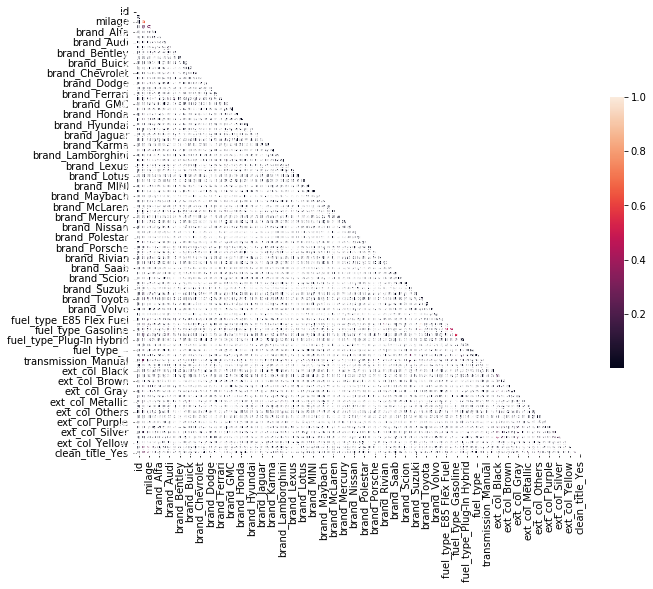

In [60]:
corr=np.abs(df.corr()) # corr(x,y) = corr(y, x), corr(x,x) = 1

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

In [79]:
corr

,id,model_year,milage,price,brand_Alfa,brand_Aston,brand_Audi,brand_BMW,brand_Bentley,brand_Bugatti,...,ext_col_Orange,ext_col_Others,ext_col_Pink,ext_col_Purple,ext_col_Red,ext_col_Silver,ext_col_White,ext_col_Yellow,accident_None reported,clean_title_Yes
id,1.000000,0.000076,0.001834,0.000877,0.003671,0.000773,0.001965,0.000252,0.001004,0.002305,...,0.003781,0.000985,0.002174,0.003268,0.000971,0.001592,0.002309,0.000819,0.000433,0.002355
model_year,0.000076,1.000000,0.669936,0.231795,0.040998,0.000252,0.042473,0.017149,0.020381,0.000432,...,0.005145,0.072597,0.001435,0.033868,0.052409,0.110038,0.041042,0.046228,0.256367,0.264893
milage,0.001834,0.669936,1.000000,0.283067,0.041551,0.018970,0.032600,0.037855,0.054478,0.007341,...,0.024028,0.071681,0.003449,0.016628,0.019597,0.090771,0.004829,0.000831,0.321356,0.242779
price,0.000877,0.231795,0.283067,1.000000,0.006204,0.030892,0.009024,0.000872,0.085061,0.009719,...,0.010018,0.074533,0.000271,0.006717,0.007063,0.041867,0.011992,0.000221,0.125122,0.089433
brand_Alfa,0.003671,0.040998,0.041551,0.006204,1.000000,0.002142,0.014916,0.018986,0.004731,0.000367,...,0.002445,0.037406,0.000666,0.002613,0.006810,0.015931,0.023243,0.000727,0.022881,0.026872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ext_col_Silver,0.001592,0.110038,0.090771,0.041867,0.015931,0.001866,0.010633,0.006162,0.016610,0.002028,...,0.026056,0.031031,0.003677,0.014439,0.085999,1.000000,0.194406,0.024236,0.035523,0.010868
ext_col_White,0.002309,0.041042,0.004829,0.011992,0.023243,0.004639,0.010163,0.000948,0.003633,0.006436,...,0.045709,0.054435,0.006451,0.025329,0.150863,0.194406,1.000000,0.042515,0.005620,0.025639
ext_col_Yellow,0.000819,0.046228,0.000831,0.000221,0.000727,0.000526,0.012999,0.004287,0.001961,0.000444,...,0.005698,0.006786,0.000804,0.003158,0.018808,0.024236,0.042515,1.000000,0.005151,0.017063
accident_None reported,0.000433,0.256367,0.321356,0.125122,0.022881,0.013503,0.002725,0.024695,0.026833,0.003241,...,0.006432,0.031297,0.003558,0.005896,0.007369,0.035523,0.005620,0.005151,1.000000,0.143870


In [66]:
corr["price"].sort_values(ascending=False).head(30)

price                      1.000000
milage                     0.283067
model_year                 0.231795
accident_None reported     0.125122
brand_Lamborghini          0.096029
clean_title_Yes            0.089433
brand_Bentley              0.085061
brand_Porsche              0.083728
ext_col_Others             0.074533
brand_Rolls-Royce          0.063496
ext_col_Silver             0.041867
brand_Toyota               0.041476
brand_Ferrari              0.040383
transmission_Manual        0.038424
fuel_type_E85 Flex Fuel    0.037381
brand_McLaren              0.036181
fuel_type_Electric         0.035543
brand_Subaru               0.032079
brand_Mercedes-Benz        0.031445
brand_Aston                0.030892
fuel_type_Hybrid           0.028522
brand_Mazda                0.028462
ext_col_Gray               0.028424
brand_Honda                0.028388
brand_Land                 0.027296
brand_Nissan               0.027085
ext_col_Green              0.026719
brand_Rivian               0

### Train Test Split

x_train = train[['model_year', 'milage','brand_Ford','brand_Mercedes-Benz','brand_BMW','brand_Chevrolet','brand_Audi']]
y_train = train["price"]

x_test = test[['model_year','milage']]

In [144]:
df = df[['model_year', 'milage','brand_Ford','brand_Mercedes-Benz','brand_BMW','brand_Chevrolet','brand_Audi','fuel_type_Diesel',
       'fuel_type_E85 Flex Fuel', 'fuel_type_Electric', 'fuel_type_Gasoline','ext_col_Black', 'ext_col_White', 'ext_col_Gray', 'ext_col_Silver','accident_At least 1 accident or damage reported','clean_title_Yes','price']]

In [139]:
x_train = df[['model_year', 'milage','brand_Ford','brand_Mercedes-Benz','brand_BMW','brand_Chevrolet','brand_Audi','fuel_type_Diesel',
       'fuel_type_E85 Flex Fuel', 'fuel_type_Electric', 'fuel_type_Gasoline','ext_col_Black', 'ext_col_White', 'ext_col_Gray', 'ext_col_Silver','accident_At least 1 accident or damage reported','clean_title_Yes']]
y_train = df["price"]

### Regression Model & Evaluation

- KNN Regression (Aisyah)
- Linear Regression (Aisyah)
- Decision Trees (Paola)
- Bagging and Pasting (Paola)
- Random Forest (Flory)
- Gradient Boosting (Flory)
- Adaptive Boosting (Paola)

**KNN Regression**

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
knn = KNeighborsRegressor(n_neighbors=10) # K = 10

In [ ]:
knn.fit(X_train, y_train)

In [ ]:
pred = knn.predict(X_test)

In [ ]:
print("MAE", mean_absolute_error(pred, y_train))
print("RMSE", mean_squared_error(pred, y_train, squared=False))
print("R2", knn.score(X_test, y_test): .2f)

**Linear Regression Model**

In [140]:
lin_reg = LinearRegression()

In [141]:
lin_reg.fit(x_train, y_train)

LinearRegression()

In [ ]:
pred = lin_reg.predict(x_train)

In [ ]:
print("MAE", mean_absolute_error(pred, y_train))
print("RMSE", mean_squared_error(pred, y_train, squared=False))
print("R2", lin_reg.score(x_train, y_train))